# Linear Regression with Gradient Descent

In this notebook, we have created a machine learning model to predict salaries based on a set of factors, by mapping them to the salary using linear regression. The model is trained using stochastic gradient descent (SGD), with maximum of 1000 iterations. We want to compare it with Linear Regression Model training using Ordinary Least Squares Method (OLS), as well model made using Gradient Boosting.

In [1]:
#all required libraries
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/process/clean_ai_salary_2025_merged_final.csv')
df.head(10)

,job_id,job_title,salary_usd,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,ML Engineer,61895,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics
5,AI00006,AI Architect,123574,SE,CT,Germany,M,Germany,50,"Data Visualization, R, SQL, Linux",Associate,7,Healthcare,2024-08-31,2024-10-04,819,5.9,Neural Networks Co
6,AI00007,Data Scientist,79670,MI,FL,United Kingdom,S,United Kingdom,0,"R, Docker, MLOps",Associate,3,Gaming,2024-12-29,2025-02-28,1936,6.3,DataVision Ltd
7,AI00008,NLP Engineer,70640,EN,FL,France,L,France,0,"Python, SQL, Computer Vision, Java, Azure",Master,0,Healthcare,2024-06-07,2024-07-01,1286,7.6,Cloud AI Solutions
8,AI00009,Data Analyst,160710,SE,CT,Singapore,L,Singapore,0,"Hadoop, Git, Mathematics, Python",PhD,7,Government,2024-11-04,2024-11-24,551,9.3,Quantum Computing Inc
9,AI00010,ML Engineer,102557,SE,PT,Austria,M,Austria,0,"MLOps, GCP, Scala, Azure, Linux",Master,5,Government,2024-10-20,2024-11-06,2340,5.8,Cloud AI Solutions


Our dataset sample consists of 18 features; however, most of them were not used in the mapping the model due to noise -- not every feature influenced the final output (salary in USD) the same manner. Trying to map all of them would have lead a non-convergent model that did not map the relationship between the input and output labels at all.
<br> <br>

Jerry and Kyle's `Linear Regression OLS (larger dataset).ipynb` goes into it in much more detail, and it is from their model that we derived the core features used below: **years_experience**, **remote_ratio**, **job_title**, **experience_level**, **company_location**, **education_required**, and **employment_type**.
<br> <br>

The core features are divided into "**Numerical Features**" and "**Categorical Features**" based on their value type: features with numerical inputs are categorized under the former, while features with non-numerican inputs (e.g.: job_title) are categorized under the latter.

In [3]:
#(this code snippet SOURCED from Klye and Jerry, Linear Regression OLS (larger dataset).ipynb)
numeric_features = ["years_experience", "remote_ratio"]
categorical_features = [
    "experience_level",
    "job_title",
    "company_location",
    "education_required",
    "employment_type"
]
X = df[numeric_features + categorical_features]
y = df["salary_usd"]

# Fill numeric NaNs with median
for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

# Fill categorical NaNs with mode
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])

/var/folders/wv/kd52qsbj0wxgs7pw25kp0jdr0000gn/T/ipykernel_83557/3286150707.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
/var/folders/wv/kd52qsbj0wxgs7pw25kp0jdr0000gn/T/ipykernel_83557/3286150707.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].median())
/var/folders/wv/kd52qsbj0wxgs7pw25kp0jdr0000gn/T/ipykernel_83557/3286150707.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Here is how we implemented our model pipeline for training and testing:
<br><br>

**Numeric features** → `StandardScaler(zero mean, unit variance)`

**Categorical features** → `OneHotEncoder(handle_unknown="ignore")`

**Combine both with ColumnTransformer**

This allows us to streamline and automate the entire scaling, training, and testing process.

*   `StandardScaler` scales numerical values such that the difference in value ranges between different numerical features is substantially reduced. It does so by transforming the data such that its mean is 0, and its standard-deviation is 0 This is important so as to prevent features with generally larger values from dominating gradient descent. In our numerical feature set, `remote_ratio` (value range: [0,150]) has a larger range of values than `years_experience` (value rage: [0,20)); if we did not scale them, `remote_ratio` would have disproportionate influence over GD training.
*   `OneHotEncoder` encodes categorical variables into binary digits.
*   `ColumnTransfer` applies `StandardScaler` to our `numerical_features`, and `OneHotEncoder` to `categorical_features`.





In [4]:
#(SOURCED FROM: Klye and Jerry)

# Pipeline for numeric columns: just scale them
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Transformer for categorical columns: one-hot encode them
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine them into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# SGDRegressor

**`SGDRegressor`** is a powerful class within Scikit-Learn that facilitates the creation of a linear regression model using stochastic gradient descent. It contains built-in parameters and functions that streamline and automate mapping and training our machine learning model. Some of its important parameters include:
*   `loss`: the loss function of our model. Default to 'squared_error', which is just the average of the square of actual and predicted values.
*   `penalty`: regularization function meant to prevent fitting. Default is 'l2' (Lasso Ridge Regularization) which decreases big weights towards (but not exactly) zero.
*   `max_iter`: maximum number of times the model is allowed to go through training
*   `tol`: stands for 'tolerance'. It sets a threshold for improvement after each iteration, and if improvement falls short of that threshold after several consecutive trials, the training stops -- regardless of if the model converged or not.
*   `random_state`: used in shuffling the dataset, for reproducibility.
<br>

To learn more about SGDRegressor, go to: [SGDRegressor — scikit-learn 1.7.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)





In [5]:
#initializing our linear regressing (gradient descent model)
LR_GD = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('sgd', SGDRegressor(loss='squared_error',
                         penalty='l2',
                         max_iter=1000,
                         tol=1e-3,
                         random_state=42))
])

# 5-fold Cross-validation
A validation technique where the dataset is divided into 5 parts - 4 parts for training and 1 part for testing. The part selected for testing changes after every iteration (hence there are 5 iterations total). This is useful to prevent overfitting and to check if model maps onto data, and if not, what steps to take.

# Metrics
(__Partially Sourced from Jerry and Kyle__)<br>
Here are the metrics we used to measure the performance of our model, in both validation, training, and testing:
- **R^2**

  - This is the coefficient of determination. It measure how much of the variation in the salary that our model can explain. "Accuracy".
  This the great for a linear reg. model when the salary is noisy, job titles vary widely, and countries differ ramatically.

- **MAE**

  - Mean Absolute Error: On average, the predictions are off by about $16,200 With a salary dataset where salaries range from 30k to 260k, an error of 16k is reasonable, because MAE within ~10-20% of target scale is a good model. Our model shows a 7-12% of salary range.

- **RMSE**
  - Root Mean Square Error: Measure average error, but penalizes large errors more. Sometimes model make large mistakes (+- 30k to +- 30k). This is because of the following:
    - Executive roles skew high
    - Senior ML engineers vs entry-level jobs differ by $100k
    - Country base salary (Example: US vs India)
- **Overfitting Check (during testing)**
    - Checks for overfitting by taking the difference in r^2 values for the training and test performance. Larger values (r^2_diff > 0.05) indicate overfitting, while smaller values pass the test with no overfitting warning.





In [6]:
#splitting and 5-fold cross-validation of data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#implementation of 5-fold cross-validation; if R^2 > 0.75 (with low std), our data is good to go

cv_scores = cross_val_score(LR_GD, X_train, y_train, cv=5, scoring='neg_mean_squared_error') # Use negative MSE because sklearn expects a "higher is better" metric
cv_scores = np.sqrt(-cv_scores) # Convert negative MSE to RMSE
print("RMSE for each fold:", cv_scores)
print("Mean RMSE:", cv_scores.mean())

#(SOURCED FROM: Klye and Jerry)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(LR_GD, X, y, cv=kf)

r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"5-Fold CV Results:")
print(f"R²:   {r2:.3f}")
print(f"MAE:  {mae:,.0f} USD")
print(f"RMSE: {rmse:,.0f} USD")

RMSE for each fold: [21282.84072086 21051.00933173 21317.53175854 21169.34080961
 20857.02238235]
Mean RMSE: 21135.549000619227
5-Fold CV Results:
R²:   0.826
MAE:  16,112 USD
RMSE: 21,154 USD


In [7]:
#Train the Model
LR_GD.fit(X_train, y_train)

#Post-training output performance

# Make predictions
y_train_pred = LR_GD.predict(X_train)
y_test_pred = LR_GD.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Print results
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

print("\n 🔄 Iterations")
print(f"     Number of iterations:    {LR_GD['sgd'].n_iter_}")
print(f"     Max iterations:    {LR_GD['sgd'].max_iter}")

print("\n📊 R² Score (Coefficient of Determination):")
print(f"   Training:   {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"   Test:       {test_r2:.4f} ({test_r2*100:.2f}%)")

print("\n💵 Mean Absolute Error (MAE):")
print(f"   Training:   ${train_mae:,.2f}")
print(f"   Test:       ${test_mae:,.2f}")

print("\n📈 Root Mean Squared Error (RMSE):")
print(f"   Training:   ${train_rmse:,.2f}")
print(f"   Test:       ${test_rmse:,.2f}")

print("\n📉 Mean Squared Error (MSE):")
print(f"   Training:   ${train_mse:,.2f}")
print(f"   Test:       ${test_mse:,.2f}")

# Check for overfitting
print("\n🔍 Overfitting Check:")
r2_diff = train_r2 - test_r2
if r2_diff < 0.05:
    print(f"   ✅ No overfitting (difference: {r2_diff:.4f})")
elif r2_diff < 0.10:
    print(f"   ⚠️  Slight overfitting (difference: {r2_diff:.4f})")
else:
    print(f"   ❌ Overfitting detected (difference: {r2_diff:.4f})")

print("\n" + "="*60)

MODEL PERFORMANCE METRICS

 🔄 Iterations
     Number of iterations:    46
     Max iterations:    1000

📊 R² Score (Coefficient of Determination):
   Training:   0.8275 (82.75%)
   Test:       0.8237 (82.37%)

💵 Mean Absolute Error (MAE):
   Training:   $16,044.90
   Test:       $16,198.66

📈 Root Mean Squared Error (RMSE):
   Training:   $21,046.68
   Test:       $21,236.66

📉 Mean Squared Error (MSE):
   Training:   $442,962,640.64
   Test:       $450,995,638.14

🔍 Overfitting Check:
   ✅ No overfitting (difference: 0.0038)



# Model Performance Visualization
Below are two of plots visualizing the performance of the model across training *and* test datasets using **actual values, predicted values and residual plot.**


*   First pair of plots is between **Predicted Salary** (y-axis) vs. **Actual Salary** (x-axis). One pair is for the training dataset, while the second pair is for the test dataset.
*   The second plot is between the **Residual** (y-axis) vs. **Predicted Salary** (x-axis). It is *only* across the test dataset.



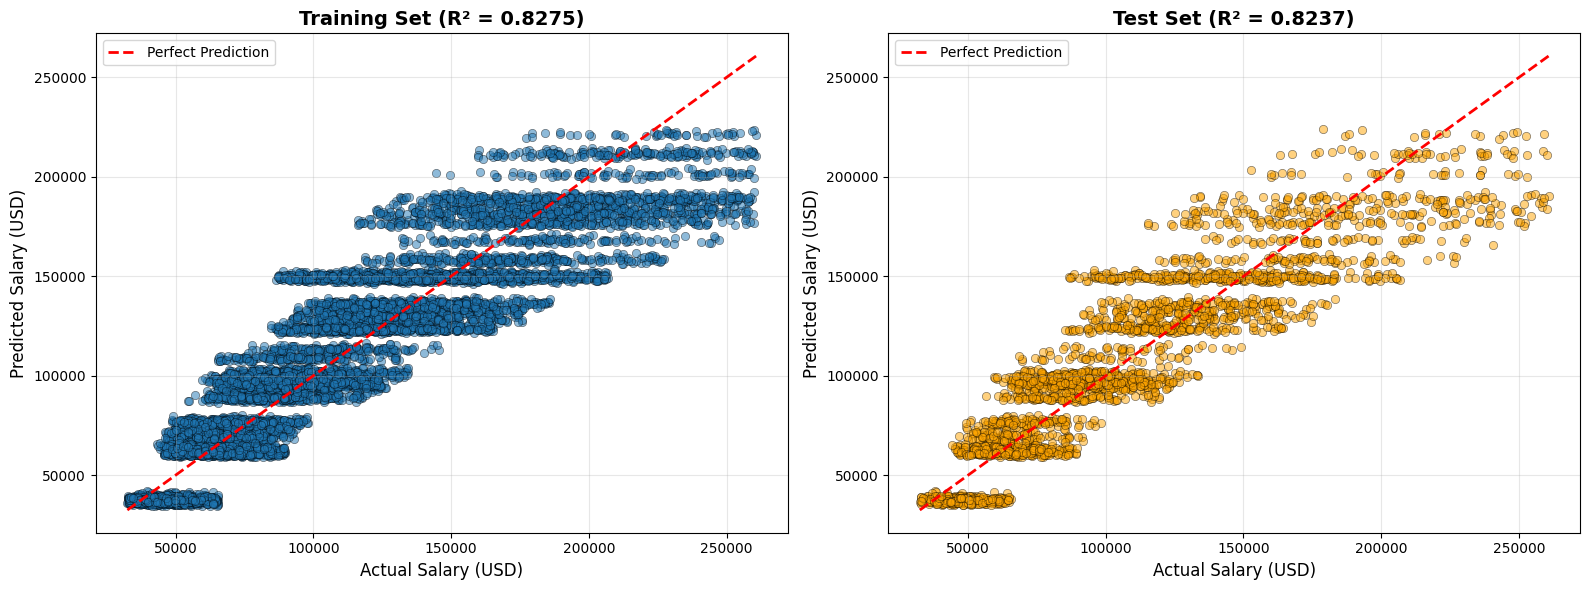

In [8]:
#actual vs predicted values plot (training and testing separate)

# Make predictions
y_train_pred = LR_GD.predict(X_train)
y_test_pred = LR_GD.predict(X_test)

# Calculate R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Training set
ax1.scatter(y_train, y_train_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Salary (USD)', fontsize=12)
ax1.set_ylabel('Predicted Salary (USD)', fontsize=12)
ax1.set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test set
ax2.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5, color='orange')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Salary (USD)', fontsize=12)
ax2.set_ylabel('Predicted Salary (USD)', fontsize=12)
ax2.set_title(f'Test Set (R² = {test_r2:.4f})', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

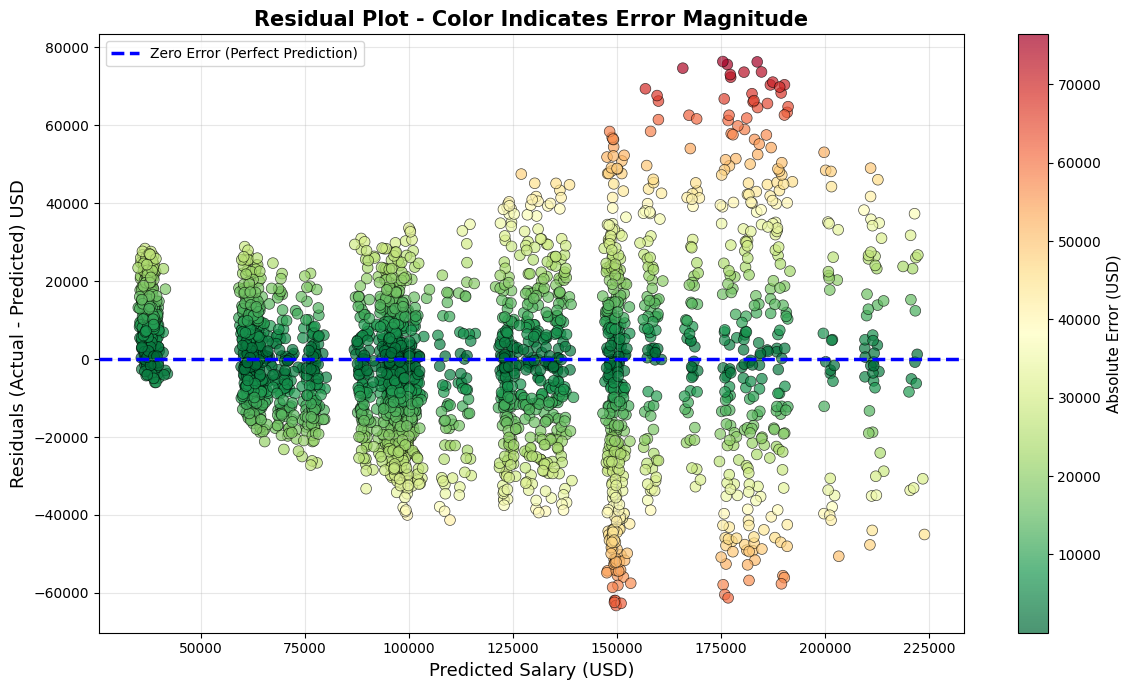

In [9]:
#residual vs predicted value plot

# Make predictions
y_pred = LR_GD.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Calculate absolute errors for coloring
abs_errors = np.abs(residuals)

# Create plot
plt.figure(figsize=(12, 7))

# Scatter with color gradient based on error magnitude
scatter = plt.scatter(y_pred, residuals, c=abs_errors, cmap='RdYlGn_r',
                     alpha=0.7, edgecolors='k', s=60, linewidth=0.5)

# Color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (USD)', fontsize=11)

# Zero line
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2.5,
            label='Zero Error (Perfect Prediction)', zorder=5)

# Labels
plt.xlabel('Predicted Salary (USD)', fontsize=13)
plt.ylabel('Residuals (Actual - Predicted) USD', fontsize=13)
plt.title('Residual Plot - Color Indicates Error Magnitude', fontsize=15, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()